In [128]:
import os
import cv2
import numpy as np
import pandas as pd
from timeit import default_timer as timer
%matplotlib inline

In [19]:
from keras.utils import Sequence

Using TensorFlow backend.


In [20]:
def read_class():
    CLASS_NAME = []
    with open('./classes.txt', 'r') as class_file:
        for i, line in enumerate(class_file):
            line = line.rstrip('\n')
            CLASS_NAME.append(line)
    print(CLASS_NAME)

In [33]:
""" Hyperparameters defined here """
NUM_CLASS = len(CLASS_NAME)
TRAIN_DF  = []
TEST_DF   = []
DATA_PATH = '/Volumes/JS/QuickDraw/'
NUM_VALID = 80

In [48]:
def split_dataset():
    all_npy_path = DATA_PATH + 'data_split/train_simplified'
    train_npy_path = DATA_PATH + 'data_split/train_set'
    valid_npy_path = DATA_PATH + 'data_split/valid_set'

    for name in CLASS_NAME:
        name = name.replace('_', ' ')
        df = pd.read_csv(DATA_PATH + 'train_simplified/%s.csv' % name)
        key_id = df['key_id'].values.astype(np.int64)
        np.random.shuffle(key_id)

        n = len(key_id)
        n_valid = NUM_VALID
        n_train = n - n_valid

        np.save(all_npy_path + '/%s.npy' % name, key_id)
        np.save(train_npy_path + '/%s.npy' % name, key_id[:n_train])
        np.save(valid_npy_path + '/%s.npy' % name, key_id[n_train:])
    print('Finish dataset split.')

In [49]:
split_dataset()

In [50]:
class Struct(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time ).astype(np.int32)

    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)

    return image


def null_augment(drawing, label, index):
    cache = Struct(drawing = drawing.copy(), label = label, index=index)
    image = drawing_to_image(drawing, 64, 64)
    return image, label, cache

def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

In [83]:
class ImageConvertor(Sequence):
    def __init__(self, data, split='train_set', augment=null_augment, mode='simplified'):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        start = timer()
        
        self.data = data
        self.augment = augment
        self.mode = mode 
        self.split = split

        self.df     = []
        self.id     = []

        if self.data == 'train':
            TRAIN_DF = []
            # countrycode, drawing, key_id, recognized, timestamp, word

            if TRAIN_DF == []:
                for i, name in enumerate(CLASS_NAME):
                    print('\r\t load df   :  %3d/%3d %24s  %s'%(i,NUM_CLASS, name,time_to_str((timer() - start),'sec')),
                          end='',flush=True)
                    name = name.replace('_', ' ')

                    df = pd.read_csv(DATA_PATH + 'train_%s/%s.csv'%(self.mode, name))
                    TRAIN_DF.append(df)
                print('\n')
            self.df = TRAIN_DF
            
            for i, name in enumerate(CLASS_NAME):
                print('\r\t load split:  %3d/%3d %24s  %s'%(i, NUM_CLASS,name,time_to_str((timer() - start),'sec')), 
                      end='', flush=True)
                name = name.replace('_', ' ')
                df = TRAIN_DF[i]
                key_id = np.load(DATA_PATH + 'data_split/%s/%s.npy'%(self.split,name))
                label = np.full(len(key_id), i, dtype=np.int64)
                drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                self.id.append(np.vstack([label, drawing_id, key_id]).T)
            self.id = np.concatenate(self.id)
            print('\n')

        if self.data == 'test':
            TEST_DF = []
            # key_id, countrycode, drawing

            if TEST_DF == []:
                TEST_DF = pd.read_csv(DATA_PATH + 'test_%s.csv'%(self.mode))
                self.id = np.arange(0,len(TEST_DF))

            self.df = TEST_DF

        print('')

    def __str__(self):
        N = len(self.id)
        string = ''\
        + '\tdata         = %s\n'%self.data \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, index):
        if self.data == 'train':
            label, drawing_id, key_id = self.id[index]
            drawing = self.df[label]['drawing'][drawing_id]
            drawing = eval(drawing)

        if self.data == 'test':
            label=None
            drawing = self.df['drawing'][index]
            drawing = eval(drawing)

        return self.augment(drawing, label, index)

    def __len__(self):
        return len(self.id)


In [84]:
dataset = ImageConvertor(data='train', split='train_set')
print(dataset)

	 load df   :  339/340                   zigzag   9 min 46 sec


0
	 load split:    0/340         The_Eiffel_Tower   9 min 46 sec
1
	 load split:    1/340  The_Great_Wall_of_China   9 min 47 sec
2
	 load split:    2/340            The_Mona_Lisa   9 min 48 sec
3
	 load split:    3/340                 airplane   9 min 48 sec
4
	 load split:    4/340              alarm_clock   9 min 49 sec
5
	 load split:    5/340                ambulance   9 min 49 sec
6
	 load split:    6/340                    angel   9 min 50 sec
7
	 load split:    7/340         animal_migration   9 min 50 sec
8
	 load split:    8/340                      ant   9 min 51 sec
9
	 load split:    9/340                    anvil   9 min 51 sec
10
	 load split:   10/340                    apple   9 min 52 sec
11
	 load split:   11/340                      arm   9 min 52 sec
12
	 load split:   12/340                asparagus   9 min 53 sec
13
	 load split:   13/340                      axe   9 min 53 sec
14
	 load split:   14

	 load split:  244/340           roller_coaster  12 min 00 sec
245
	 load split:  245/340             rollerskates  12 min 01 sec
246
	 load split:  246/340                 sailboat  12 min 01 sec
247
	 load split:  247/340                 sandwich  12 min 01 sec
248
	 load split:  248/340                      saw  12 min 02 sec
249
	 load split:  249/340                saxophone  12 min 03 sec
250
	 load split:  250/340               school_bus  12 min 03 sec
251
	 load split:  251/340                 scissors  12 min 04 sec
252
	 load split:  252/340                 scorpion  12 min 04 sec
253
	 load split:  253/340              screwdriver  12 min 05 sec
254
	 load split:  254/340               sea_turtle  12 min 06 sec
255
	 load split:  255/340                  see_saw  12 min 06 sec
256
	 load split:  256/340                    shark  12 min 06 sec
257
	 load split:  257/340                    sheep  12 min 07 sec
258
	 load split:  258/340                     shoe  12 min 07 sec

4970424 AxesSubplot(0.125,0.657941;0.227941x0.222059)
25372089 AxesSubplot(0.398529,0.657941;0.227941x0.222059)
33985121 AxesSubplot(0.672059,0.657941;0.227941x0.222059)
13181873 AxesSubplot(0.125,0.391471;0.227941x0.222059)
39828425 AxesSubplot(0.398529,0.391471;0.227941x0.222059)
37680663 AxesSubplot(0.672059,0.391471;0.227941x0.222059)
575252 AxesSubplot(0.125,0.125;0.227941x0.222059)
44283121 AxesSubplot(0.398529,0.125;0.227941x0.222059)
44481137 AxesSubplot(0.672059,0.125;0.227941x0.222059)


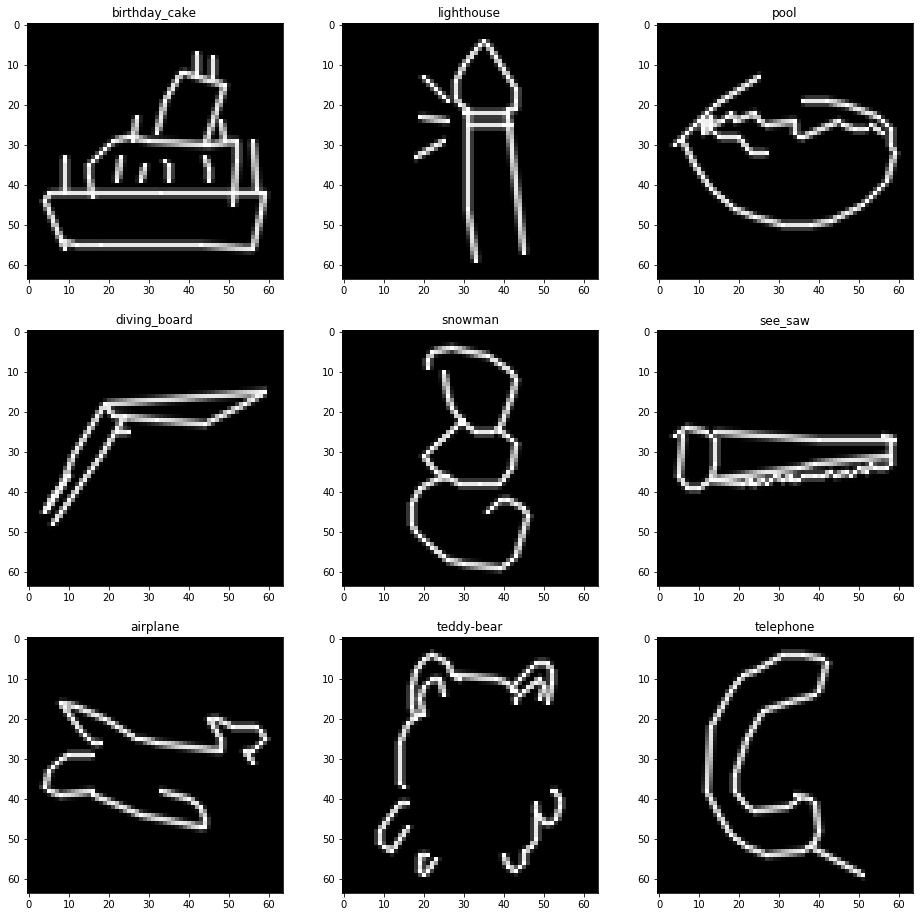

In [151]:
fig, m_axs = plt.subplots(3, 3, figsize=(16, 16))
rand_idxs = np.random.choice(range(len(dataset)), size=9)

for img_id, ax in zip(rand_idxs, m_axs.flatten()):
    print(img_id, ax)
    img = dataset[img_id][0]
    ax.imshow(img.astype('uint8'))
    ax.set_title(CLASS_NAME[dataset[img_id][1]])